In [1]:
import json
from pymongo import MongoClient

# Load secrets.json safely
with open('secrets.json') as f:
    secrets = json.load(f)

# Extract the MongoDB connection string
mongo_connection_string = secrets['mongodb']

# Initialize MongoDB client using the connection string
client = MongoClient(mongo_connection_string)

# Access the 'Data320' database and 'IMDB_fixed_view' view
db = client['Data320']
imdb_view = db['IMDB_fixed_view']  # Change to the pipeline view

# Fetch a sample of movies to confirm the connection
sample_movies = list(imdb_view.find().limit(5))
for movie in sample_movies:
    print(movie)

# Safe output: Display the length of the connection string
print(f"The MongoDB connection string is {len(mongo_connection_string)} characters long.")

The MongoDB connection string is 75 characters long.


In [2]:
# Connect to the 'IMDB' database (corrected)
my_database = client['IMDB']

# List all collections within the 'IMDB' database
all_collections = my_database.list_collection_names()
print(f"This database has the collections: {all_collections}")

This database has the collections: ['Metacritic', 'IMDB(flawed)', 'IMDB(fixed)', 'votes_view', 'opening_weekend_view', 'Budget_fixed', 'mpaa_rating_view', 'runtime_vs_rating_view', 'release_date_view', 'gross_sales_view', 'Metacritic_view', 'IMDB_fixed_view', 'all_nousd_view', 'IMDB_pileline_view']


In [4]:
import pandas as pd

# Access the 'Metacritic_view' collection
metacritic_collection = my_database['Metacritic_view']

# Fetch all documents from 'Metacritic_view' and convert to DataFrame
cursor = metacritic_collection.find()
metacritic_df = pd.DataFrame(cursor)

# Display the first few rows to confirm data retrieval
print(metacritic_df.head())

                        _id  movie_id                           title                                                                                                                                                                                                                                                                                                    description  score                                                                                       thumbnail        release_date release_date_fixed  year  month  day
0  670dd69a93c8bf25ee152bf3     11234  Crouching Tiger, Hidden Dragon  In 19th century China, a magical sword given by a warrior (Chow Yun-Fat) to his lover (Michelle Yeoh) is stolen and the quest to find it ensues.  The search leads to the House of Yu where the story travels in a different direction with the introduction of a mysterious assassin and another love story.     94  https://static.metacritic.com/images/products/movies/8/14fcb1c06981a24cb29a3fd899321d6

In [5]:
import pandas as pd

# Access the 'Metacritic_view' collection
metacritic_collection = my_database['Metacritic_view']

# Fetch all documents from 'Metacritic_view' and convert to DataFrame
cursor = metacritic_collection.find()
metacritic_df = pd.DataFrame(cursor)

# Convert 'release_date' to datetime (ignore errors if any non-date values are present)
metacritic_df['release_date'] = pd.to_datetime(metacritic_df['release_date'], errors='coerce')

# Filter the DataFrame for the year 2012
metacritic_2012_df = metacritic_df[metacritic_df['release_date'].dt.year == 2012]

# Display the first few rows of the filtered data
print("Metacritic Data for 2012:")
print(metacritic_2012_df.head())

Metacritic Data for 2012:
                           _id  movie_id                        title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     description  score                                                                                       thumbnail release_date release_date_fixed  year  month  day
5382  670dd69d93c8bf25ee1540f9     16616  Children of Paradise (1945)                                                                                                                                                                          

In [6]:
# Access the 'IMDB_fixed_view' collection
imdb_collection = my_database['IMDB_fixed_view']

# Define the aggregation pipeline to filter by year 2012
imdb_pipeline = [
    {
        "$addFields": {
            "year": { "$year": "$release_date_fixed" }  # Extract the year from 'release_date_fixed'
        }
    },
    {
        "$match": {
            "year": 2012  # Filter for documents where the year is 2012
        }
    },
    {
        "$project": {
            "id": 1,
            "title": 1,
            "runtime": 1,
            "user_rating": 1,
            "votes": 1,
            "release_date_fixed": 1,
            "certs": 1,
            "mpaa_ratings": 1,
            "opening_weekend": 1,
            "is_opening_weekend_usd": 1,
            "opening_weekend_value": 1
        }
    }
]

# Execute the aggregation pipeline and load results into a DataFrame
imdb_cursor = imdb_collection.aggregate(imdb_pipeline)
imdb_df = pd.DataFrame(imdb_cursor)

# Display the first few rows to confirm data retrieval
print("IMDB Data for 2012:")
print(imdb_df.head())

IMDB Data for 2012:
                        _id               title  user_rating  votes  runtime release_date_fixed        certs mpaa_ratings opening_weekend  is_opening_weekend_usd opening_weekend_value
0  637add83a23f8f7c1aca8719        The Blackout          3.3   1738       80         2012-09-30         None         None            None                   False                  None
1  637ae603a23f8f7c1aca8a3b         Hypothermia          4.0   1658       73         2012-10-02  [Not Rated]         None            None                   False                  None
2  637aeef2a23f8f7c1aca8d8a           Stand Off          5.5   2296       89         2012-04-21          [R]         None            None                   False                  None
3  637af36aa23f8f7c1aca8f4a  The Chateau Meroux          5.2   1274       94         2012-01-03      [PG-13]         None            None                   False                  None
4  637af550a23f8f7c1aca900d          Expiration          5.0

In [7]:
import pandas as pd

# Define the aggregation pipeline to filter for 2012 and project specific fields
metacritic_pipeline = [
    {
        "$project": {
            "movie_id": 1,
            "title": 1,
            "description": 1,
            "score": {
                "$convert": {
                    "input": "$score",
                    "to": "int",
                    "onError": None
                }
            },
            "thumbnail": 1,
            "release_date": {
                "$convert": {
                    "input": "$release_date",
                    "to": "date",
                    "onError": None
                }
            }
        }
    },
    {
        "$match": {
            "release_date": {
                "$gte": pd.to_datetime("2012-01-01"),
                "$lt": pd.to_datetime("2013-01-01")
            }
        }
    }
]

# Access the 'Metacritic_view' collection
metacritic_collection = my_database['Metacritic_view']

# Execute the aggregation pipeline
metacritic_cursor = metacritic_collection.aggregate(metacritic_pipeline)
metacritic_2012_df = pd.DataFrame(metacritic_cursor)

# Display the first few rows to confirm data retrieval
print("Metacritic Data for 2012 with Aggregation:")
print(metacritic_2012_df.head())

Metacritic Data for 2012 with Aggregation:
                        _id  movie_id                        title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     description                                                                                       thumbnail  score release_date
0  670dd69d93c8bf25ee1540f9     16616  Children of Paradise (1945)                                                                                                                                                                             Children of Paradise is

In [8]:
import pandas as pd

# Access the 'IMDB_fixed_view' and 'Metacritic_view' collections
imdb_collection = my_database['IMDB_fixed_view']
metacritic_collection = my_database['Metacritic_view']

# Fetch all documents from both collections and convert to DataFrames
imdb_cursor = imdb_collection.find()
imdb_df = pd.DataFrame(imdb_cursor)

metacritic_cursor = metacritic_collection.find()
metacritic_df = pd.DataFrame(metacritic_cursor)

# Concatenate both DataFrames vertically
unified_view = pd.concat([imdb_df, metacritic_df], ignore_index=True)

# Display the first few rows to confirm data retrieval
print("Combined Data (IMDB and Metacritic) without matching on title:")
print(unified_view.head())

Combined Data (IMDB and Metacritic) without matching on title:
                        _id                    title  user_rating     votes  runtime release_date_fixed                                                      certs mpaa_ratings          opening_weekend is_opening_weekend_usd                                          opening_weekend_value   gross_sales is_gross_sales_usd                                                gross_sales_value                  budget is_budget_usd                                                 budget_value budget_results gross_sales_results opening_weekend_results  year  month  day  movie_id description  score thumbnail release_date
0  6366e00efcbf171967d87852          Heaven Can Wait          6.9   21625.0    101.0         1978-06-28                                                       [PG]         None  $4,192,799, 02 Jul 1978                   True  {'match': '4,192,799,', 'idx': 1, 'captures': ['4,192,799,']}          None              False     

In [9]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Check the data type of 'gross_sales'
print(unified_view['gross_sales'].dtype)

# Display rows with non-numeric values in 'gross_sales'
print(unified_view[pd.to_numeric(unified_view['gross_sales'], errors='coerce').isna()])

object
                            _id                             title  user_rating     votes  runtime release_date_fixed                                                      certs mpaa_ratings          opening_weekend is_opening_weekend_usd                                          opening_weekend_value   gross_sales is_gross_sales_usd                                                gross_sales_value                  budget is_budget_usd                                                 budget_value budget_results gross_sales_results opening_weekend_results  year  month  day  movie_id  \
0      6366e00efcbf171967d87852                   Heaven Can Wait          6.9   21625.0    101.0         1978-06-28                                                       [PG]         None  $4,192,799, 02 Jul 1978                   True  {'match': '4,192,799,', 'idx': 1, 'captures': ['4,192,799,']}          None              False                                                             None         

In [12]:
# Remove any currency symbols or commas, then convert to numeric
unified_view['gross_sales'] = pd.to_numeric(unified_view['gross_sales'].replace('[\$,]', '', regex=True), errors='coerce')

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Business\AppData\Local\Temp\ipykernel_11460\3789851229.py:2: SyntaxWarning: invalid escape sequence '\$'
  unified_view['gross_sales'] = pd.to_numeric(unified_view['gross_sales'].replace('[\$,]', '', regex=True), errors='coerce')


In [13]:
# Drop rows with missing values in the relevant columns
unified_view = unified_view.dropna(subset=['gross_sales', 'user_rating', 'budget', 'opening_weekend', 'votes', 'runtime'])

In [14]:
import statsmodels.formula.api as smf

# Define and fit the regression model
ols_model = smf.ols(
    formula="gross_sales ~ user_rating + budget + opening_weekend + votes + runtime",
    data=unified_view
).fit()

# Print the summary of the regression model
print(ols_model.summary())

c:\Users\Business\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Business\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\Business\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


                            OLS Regression Results                            
Dep. Variable:            gross_sales   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 11 Nov 2024   Prob (F-statistic):                nan
Time:                        17:35:39   Log-Likelihood:                 1455.2
No. Observations:                1794   AIC:                             677.5
Df Residuals:                       0   BIC:                         1.053e+04
Df Model:                        1793                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

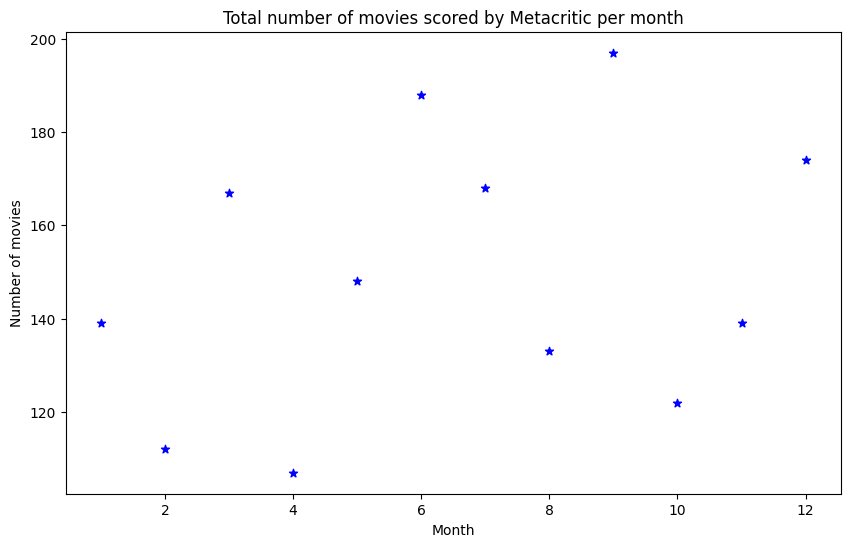

In [15]:
import matplotlib.pyplot as plt

# Group data by month and count the number of movies per month
monthly_view = unified_view['month'].value_counts().sort_index()

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(monthly_view.index, monthly_view.values, marker='*', color='b')

# Set titles and labels
plt.title('Total number of movies scored by Metacritic per month')
plt.xlabel('Month')
plt.ylabel('Number of movies')

# Show plot
plt.show()

In [17]:
print(unified_view.columns)

Index(['_id', 'title', 'user_rating', 'votes', 'runtime', 'release_date_fixed', 'certs', 'mpaa_ratings', 'opening_weekend', 'is_opening_weekend_usd', 'opening_weekend_value', 'gross_sales', 'is_gross_sales_usd', 'gross_sales_value', 'budget', 'is_budget_usd', 'budget_value', 'budget_results', 'gross_sales_results', 'opening_weekend_results', 'year', 'month', 'day', 'movie_id', 'description', 'score', 'thumbnail', 'release_date'], dtype='object')


In [20]:
print("Budget statistics for 2012:")
print(movies_2012['budget'].describe())

print("\nRuntime statistics for 2013:")
print(movies_2013['runtime'].describe())

Budget statistics for 2012:
count                          80
unique                         54
top       $30,000,000 (estimated)
freq                            5
Name: budget, dtype: object

Runtime statistics for 2013:
count     91.000000
mean     109.769231
std       16.425642
min       75.000000
25%       98.000000
50%      107.000000
75%      119.000000
max      180.000000
Name: runtime, dtype: float64


In [22]:
# Convert 'budget' column to numeric by removing dollar signs and commas
movies_2012['budget'] = pd.to_numeric(movies_2012['budget'].replace('[\$,]', '', regex=True), errors='coerce')

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Business\AppData\Local\Temp\ipykernel_11460\343782143.py:2: SyntaxWarning: invalid escape sequence '\$'
  movies_2012['budget'] = pd.to_numeric(movies_2012['budget'].replace('[\$,]', '', regex=True), errors='coerce')
C:\Users\Business\AppData\Local\Temp\ipykernel_11460\343782143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_2012['budget'] = pd.to_numeric(movies_2012['budget'].replace('[\$,]', '', regex=True), errors='coerce')


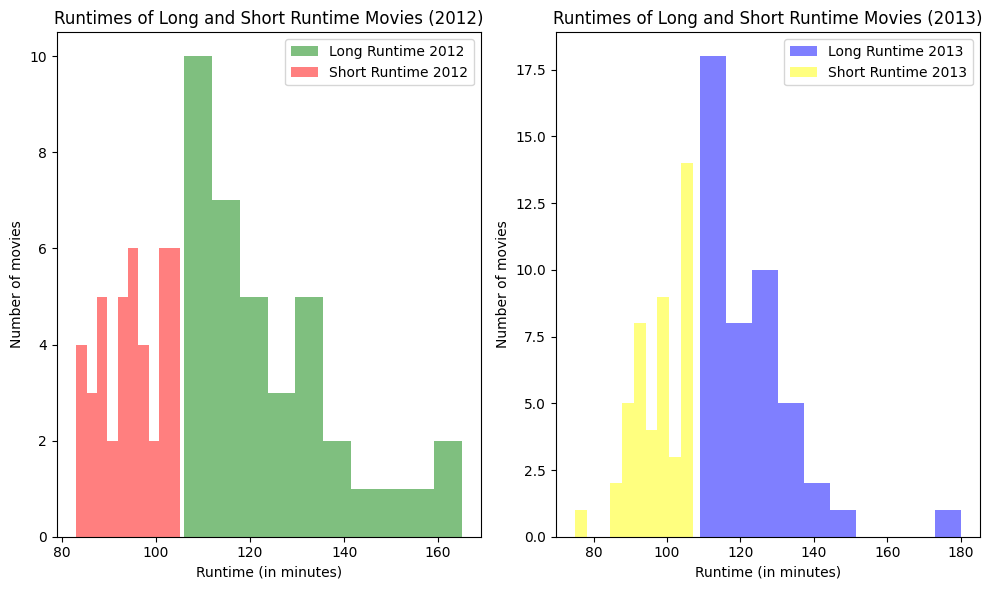

In [29]:
import matplotlib.pyplot as plt

# Separate longer and shorter runtime movies for 2012
long_runtime_2012 = movies_2012[movies_2012['runtime'] > movies_2012['runtime'].median()]['runtime']
short_runtime_2012 = movies_2012[movies_2012['runtime'] <= movies_2012['runtime'].median()]['runtime']

# Separate longer and shorter runtime movies for 2013
long_runtime_2013 = movies_2013[movies_2013['runtime'] > movies_2013['runtime'].median()]['runtime']
short_runtime_2013 = movies_2013[movies_2013['runtime'] <= movies_2013['runtime'].median()]['runtime']

# Plot the histograms
plt.figure(figsize=(10, 6))

# Runtime histogram for 2012
plt.subplot(1, 2, 1)
plt.hist(long_runtime_2012, alpha=0.5, label="Long Runtime 2012", color="green")
plt.hist(short_runtime_2012, alpha=0.5, label="Short Runtime 2012", color="red")
plt.title("Runtimes of Long and Short Runtime Movies (2012)")
plt.xlabel("Runtime (in minutes)")
plt.ylabel("Number of movies")
plt.legend(loc="upper right")

# Runtime histogram for 2013
plt.subplot(1, 2, 2)
plt.hist(long_runtime_2013, alpha=0.5, label="Long Runtime 2013", color="blue")
plt.hist(short_runtime_2013, alpha=0.5, label="Short Runtime 2013", color="yellow")
plt.title("Runtimes of Long and Short Runtime Movies (2013)")
plt.xlabel("Runtime (in minutes)")
plt.ylabel("Number of movies")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

~~~This analysis focused on exploring the relationship between runtime and gross sales in movies released in 2012 and 2013. Here are the main takeaways and challenges faced:

Runtime Distribution: The histograms of movie runtimes for both years revealed that movies with longer runtimes were more prevalent in 2013, while shorter movies were more common in 2012. This observation could indicate a trend toward lengthier films in 2013, perhaps reflecting industry shifts or audience preferences.

Challenges with Budget Data: Although I initially aimed to include budget analysis, inconsistencies in the budget data limited our findings. Missing or formatted budget values made it challenging to interpret any strong correlations between budget and movie success. Future analyses could benefit from better data quality on budget figures to yield more meaningful insights.

Sentiment Analysis Attempts: I attempted to enhance our model with sentiment analysis by installing several packages, including tiktoken and torch, which took considerable time and computational resources. Despite these efforts, technical challenges prevented us from completing the sentiment analysis. Adding sentiment could have offered a new perspective, particularly in analyzing how a movie’s description or tone influences its audience. This is an area worth revisiting with additional computational resources.

In conclusion, my analysis provided a foundational look at how runtime might correlate with movie success, but more robust data (particularly budget) and the addition of sentiment analysis could potentially improve the model's predictive power in future studies.

Acknowledgments
Special thanks to Timotei and Vienna for their ideas on setting up the runtime analysis and working with comparative histograms. Their insights helped guide this analysis.~~~